# Imports

In [1]:
from copy import deepcopy
import fiona
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import rasterio
from rasterio.warp import transform_geom
from rasterio.crs import CRS
import shapely 
from shapely.ops import unary_union
from shapely import Polygon, MultiPolygon, box
from typing import List

In [2]:
from data.config import CONFIG
from utilities.area import EARTH_RADIUS, get_density_per_area
from utilities.geojson import (
    filter_features, filter_features_by_list, filter_features_by_bounds, filter_features_by_proximity, 
    get_polygons,
    convert_dict_to_shapely,
)
from utilities.plotting import plot_polygon, plot_polygons

In [3]:
data_dir = r'..\..\datasets\geospatial'

## Boundary data
https://www.geoboundaries.org/countryDownloads.html 

In [ ]:
geojson_filepath = os.path.join(data_dir, 'borders', 'geoBoundaries-ZAF-ADM2-all/geoBoundaries-ZAF-ADM2.geojson')
# boundary = box(88.1, 22.4, 88.6, 23.0)
# boundary = box(72.7, 18.8, 73.0, 19.3)
with open(geojson_filepath, 'r') as f:
    shape_data = json.load(f)
    valid_features = filter_features_by_bounds(shape_data, boundary)

In [ ]:
valid_ids = sorted([f['properties']['shapeName'] for f in valid_features])
print(valid_ids)

## Load

In [4]:
config = CONFIG["United States"]
feature_names = [prop[0] for prop in config["features"]["New York"]]
geojson_filepath = os.path.join(data_dir, 'borders', config["geojson filepath"])
prop_name = "shapeID"
region_name = "New York, USA"

In [5]:
with open(geojson_filepath, 'r') as f:
    shape_data = json.load(f)
    features = shape_data['features']
    if feature_names:
        features_filtered = filter_features_by_list(shape_data, prop_name, feature_names)
        assert len(feature_names) == len(features_filtered)
    else:
        features_filtered = features
    admin_polygons = get_polygons(features_filtered, identifier=prop_name)

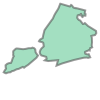

In [6]:
region_polygon = unary_union(list(admin_polygons.values()))
region_polygon

In [7]:
central_point = (region_polygon.centroid.x, region_polygon.centroid.y)
with open(geojson_filepath, 'r') as f:
    shape_data = json.load(f)
    features = shape_data['features']
    min_distance = 150e3 # metres
    features_filtered = filter_features_by_proximity(shape_data, central_point, min_distance)
    region_polygons = get_polygons(features_filtered, identifier=prop_name)

In [8]:
print(len(region_polygons))
print(all(key in region_polygons for key in admin_polygons.keys()))

53
True


### Plotting

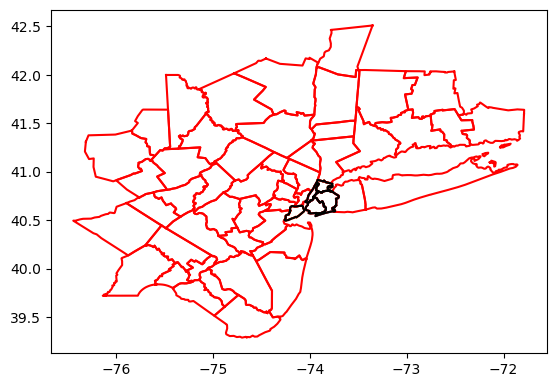

In [9]:
fig, ax = plt.subplots()
plot_polygons(ax, admin_polygons.values())
xlims = ax.get_xlim()
ylims = ax.get_ylim()
plot_polygons(ax, region_polygons.values(), 'r-')
plot_polygons(ax, admin_polygons.values(), 'k-')
# ax.set_xlim(xlims)
# ax.set_ylim(ylims)
ax.set_aspect('equal')
ax.plot();

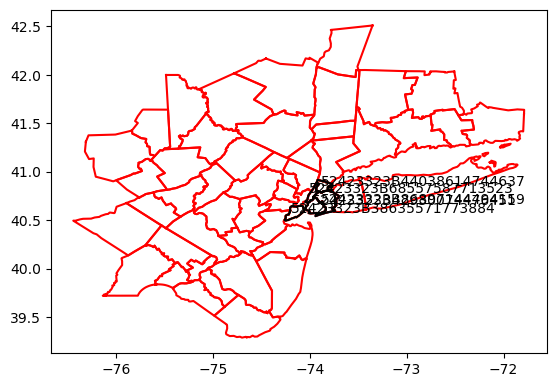

In [10]:
for key, polygon in admin_polygons.items():
    long_min, lat_min, long_max, lat_max = polygon.bounds
    long_avg = long_max * 0.3  + long_min * 0.7
    lat_avg = (lat_max + lat_min) / 2
    ax.text(long_avg, lat_avg, key)
fig

## Reproject

reproject onto a transverse mercator to remove distortion (longitude lines stretched apart)

- https://pygis.io/docs/d_raster_crs_intro.html
- http://pygis.io/docs/d_understand_crs_codes.html

In [11]:
long_min, lat_min, long_max, lat_max = region_polygon.bounds
long_avg = (long_min + long_max) / 2
long_avg

-73.98031693449997

In [12]:
dst_crs = {
    'proj': 'tmerc',
    'lat_0': 0,
    'lon_0': long_avg,
    'k': 1/1000, # convert to km
    'x_0': 0,
    'y_0': 0,
    'ellps': 'WGS84',
    'units': 'm',
    'no_defs': True
}
src_crs = CRS.from_epsg(4326)

In [13]:
admin_polygons_dst = transform_geom(
    src_crs,
    dst_crs,
    admin_polygons.values()
)
admin_polygons_dst = dict(
    (name, convert_dict_to_shapely(geom)) for name, geom in zip(admin_polygons.keys(), admin_polygons_dst)
)

In [14]:
region_polygons_dst = transform_geom(
    src_crs,
    dst_crs,
    region_polygons.values()
)
region_polygons_dst = dict(
    (name, convert_dict_to_shapely(geom)) for name, geom in zip(region_polygons.keys(), region_polygons_dst)
)

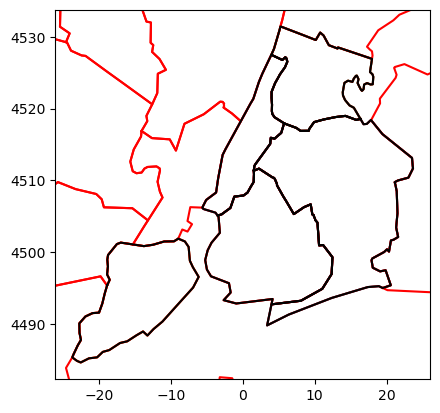

In [15]:
fig, ax = plt.subplots()
plot_polygons(ax, admin_polygons_dst.values())
xlims = ax.get_xlim()
ylims = ax.get_ylim()
plot_polygons(ax, region_polygons_dst.values(), 'r-')
plot_polygons(ax, admin_polygons_dst.values(), 'k-')
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_aspect('equal')
ax.plot();

## Population Data

https://rasterio.readthedocs.io/en/latest/quickstart.html

https://hub.worldpop.org/geodata/listing?id=78

In [16]:
raster_filepath = os.path.join(data_dir, 'rasters', config["raster filepath"]) 

In [17]:
print(region_polygon.bounds)
long_min, lat_min, long_max, lat_max = region_polygon.bounds
long_avg = (long_min + long_max) / 2
lat_avg = (lat_max + lat_min) / 2
half_length = 50_000 # metres
radius = EARTH_RADIUS
lat_unit = half_length / radius * (180 / np.pi)
long_radius = radius * np.cos(lat_avg * np.pi / 180)
long_unit = half_length / long_radius * (180 / np.pi)
new_bounds = (long_avg - long_unit, lat_avg - lat_unit, long_avg + long_unit, lat_avg + lat_unit)
print(new_bounds)

(-74.26061251699997, 40.496111205000034, -73.70002135199996, 40.91758530000004)
(-74.57349219336858, 40.25718795771115, -73.38714167563136, 41.15650854728892)


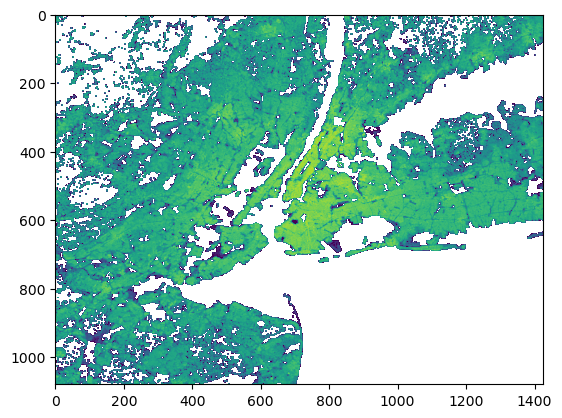

In [18]:
boundaries = [box(*new_bounds)]
#boundaries = [box(*region_polygon.bounds)]
with rasterio.open(raster_filepath) as src:
    img_region, transform_region = rasterio.mask.mask(src, boundaries, crop=True)
    img_region[img_region < 0] = 0
    crs = src.crs
plt.imshow(
    img_region[0, :, :],
    norm=matplotlib.colors.LogNorm()
);

In [19]:
channels, height, width = img_region.shape
output_filename = "output_raster.tif"
profile = {
    'driver': 'GTiff',
    'height': height,
    'width': width,
    'count': 1,  # Number of bands
    'dtype': rasterio.float32,
    'crs': crs,
    'transform': transform_region,
    'nodata': -9999
}

# Write the raster data to a file
with rasterio.open(output_filename, 'w', **profile) as dst:
    dst.write(img_region[0, :, :], 1) # Write data to band 1

In [20]:
polygons = region_polygons
polygons_dst = region_polygons_dst

In [21]:
filepath = raster_filepath
#filepath = 'output_raster.tif'
with rasterio.open(filepath) as src:
    densities, populations_counts, areas = get_density_per_area(src, polygons.values())
print(f'populations_count: {populations_counts.sum():,.2f}')
print(f'area: {areas.sum()/1e6:,.2f} km^2')
print(f'density max:  {densities.max():,.2f} people / km^2')
print(f'density mean: {densities.mean():,.2f} people / km^2')

populations_count: 31,635,906.86
area: 65,772.05 km^2
density max:  18,299.70 people / km^2
density mean: 1,539.10 people / km^2


In [22]:
for (name, density, pop) in zip(polygons.keys(), densities, populations_counts):
    if pop == 0:
        continue
    print(f'{name} : {pop:,.0f} people: {density:.2f} people/km^2')

52423323B14765757601451 : 389,497 people: 432.76 people/km^2
52423323B74073307510671 : 90,046 people: 141.54 people/km^2
52423323B46103575279257 : 375,808 people: 634.80 people/km^2
52423323B91759364179792 : 1,534,719 people: 4143.99 people/km^2
52423323B86897144494159 : 2,230,681 people: 6828.20 people/km^2
52423323B72584796071045 : 106,040 people: 113.11 people/km^2
52423323B38635571773884 : 494,340 people: 3074.40 people/km^2
52423323B11695261421482 : 517,619 people: 878.27 people/km^2
52423323B41588458909272 : 295,672 people: 138.47 people/km^2
52423323B19000754742578 : 489,246 people: 393.27 people/km^2
52423323B75013060921625 : 320,671 people: 328.04 people/km^2
52423323B94893090116384 : 283,084 people: 179.19 people/km^2
52423323B27696847619377 : 839,224 people: 665.39 people/km^2
52423323B62256411494154 : 167,463 people: 167.54 people/km^2
52423323B65115859299704 : 176,483 people: 72.25 people/km^2
52423323B25129931119647 : 123,280 people: 109.14 people/km^2
52423323B5705335225

## Clip to region of intersest

In [23]:
def prepare_polygon_patches(geometries: List[dict], values: List[float], offset: np.array):
    assert len(geometries) == len(values)
    patches = []
    colors = []
    for key_geometry, val in zip(geometries.items(), values):
        key, geometry = key_geometry
        if isinstance(geometry, MultiPolygon):
            polygons = geometry.geoms
        else:
            polygons = [geometry]
        for polygon in polygons:
            polygon = polygon.exterior.coords
            polygon += offset
            patches.append(matplotlib.patches.Polygon(polygon))
            colors.append(val)
    return patches, colors

In [24]:
cmap = plt.get_cmap('viridis')#, 10)
print(densities.max())
vmax = densities.max()
#vmax = 9970

18299.695881099302


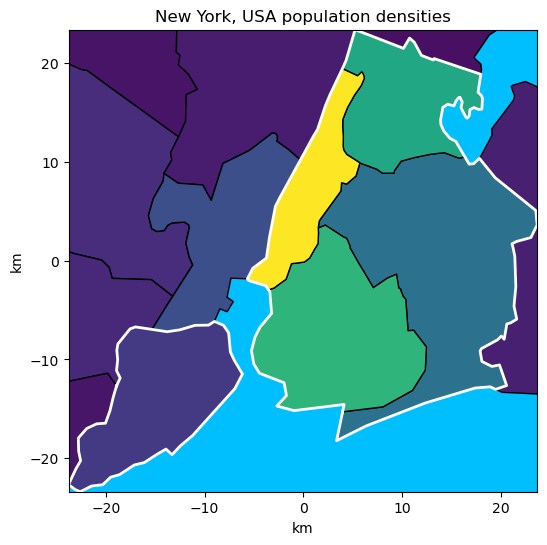

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_facecolor('deepskyblue')
ax.set_title(f'{region_name} population densities')

region_dst = unary_union(list(admin_polygons_dst.values()))
x_min, y_min, x_max, y_max = region_dst.bounds

y_mid = (y_min + y_max) / 2
origin = np.array((0.0, y_mid))
patches, colors = prepare_polygon_patches(polygons_dst, densities, -origin)
        
p = matplotlib.collections.PatchCollection(patches, edgecolor='k', cmap=cmap)
p.set_array(colors)
p.set_clim(0, vmax)
ax.add_collection(p)

plot_polygon(ax, region_dst, 'w-', linewidth=2, offset=-origin)

ax.autoscale()
ax.set_aspect('equal')
ax.set_xlabel('km')
ax.set_ylabel('km');
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min - y_mid, y_max - y_mid);

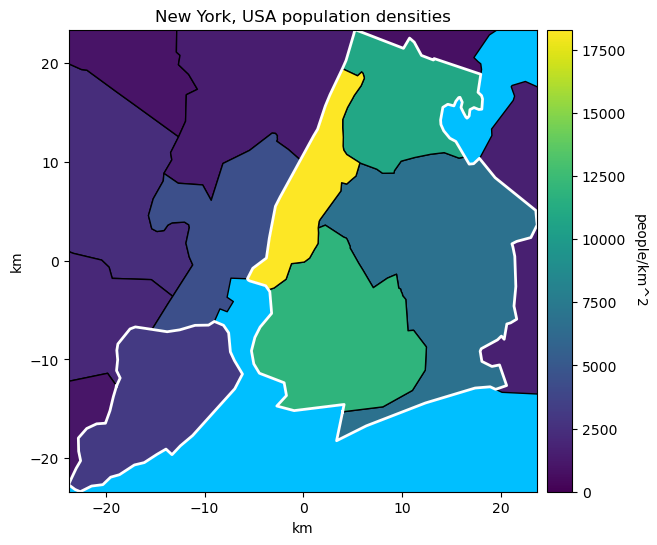

In [26]:
cbar_axis = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.025,ax.get_position().height])
cbar = fig.colorbar(p, cbar_axis)
cbar.set_label('people/km^2', rotation=270, labelpad=15) # density
fig

In [27]:
fig.savefig('images/densities_new_york.png', bbox_inches="tight")

## Compare to another city

In [28]:
config_other = CONFIG["United Kingdom"]
feature_names = [props[0] for props in config_other["features"]["London"]]
geojson_filepath = os.path.join(data_dir, 'borders', config_other["geojson filepath"])
other_name = 'London, UK'
other_raster_filepath = os.path.join(data_dir, 'rasters', config_other["raster filepath"])

In [29]:
with open(geojson_filepath, 'r') as f:
    shape_data = json.load(f)
    if feature_names is None:
        features = shape_data['features']
    else:
        features = filter_features_by_list(shape_data, 'shapeID', feature_names)
        assert len(feature_names) == len(features)
other_polygons = get_polygons(features)

In [30]:
 # population counts
with rasterio.open(other_raster_filepath) as src:
    other_densities, other_populations, other_areas = get_density_per_area(src, other_polygons.values())    
other_densities.max()

16033.424806775403

In [31]:
other_region = unary_union(list(other_polygons.values()))
other_long_min, other_lat_min, other_long_max, other_lat_max = other_region.bounds
other_long_avg = (other_long_min + other_long_max) / 2
other_crs = {
    'proj': 'tmerc',
    'lat_0': 0,
    'lon_0': other_long_avg,
    'k': 1/1000, # convert to km
    'x_0': 0,
    'y_0': 0,
    'ellps': 'WGS84',
    'units': 'm',
    'no_defs': True
}
src_crs = CRS.from_epsg(4326)

In [32]:
other_polygons_dst = transform_geom(
    src_crs,
    other_crs,
    other_polygons.values()
)
other_polygons_dst = dict(
    (name, convert_dict_to_shapely(geom)) for name, geom in zip(other_polygons.keys(), other_polygons_dst)
)

In [33]:
other_region_dst = unary_union(list(other_polygons_dst.values()))
other_x_min, other_y_min, other_x_max, other_y_max = other_region_dst.bounds
other_y_mid = (other_y_min + other_y_max) / 2
origin_other = -np.array((0, other_y_mid)) + np.array((-50, 0)) # projection already sets the latitude to 0

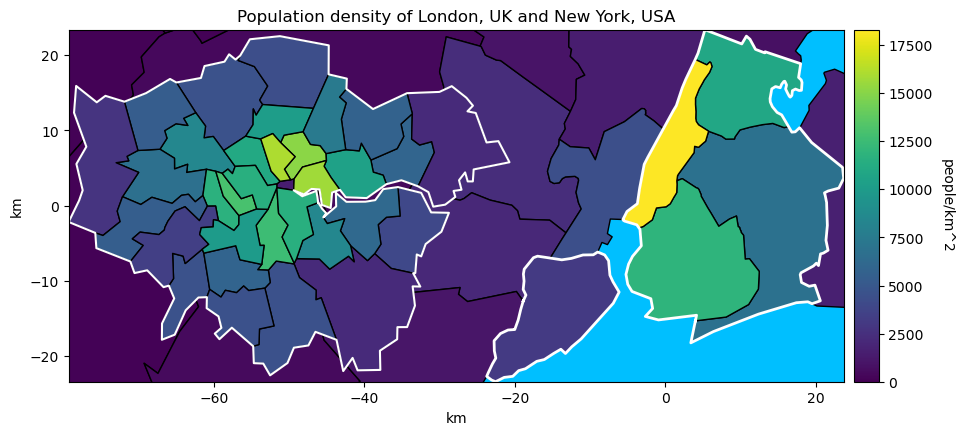

In [34]:
fig2 = deepcopy(fig)
ax2 = fig2.get_axes()[0]
fig2.get_axes()[1].remove()
ax2.set_title(f'Population density of {other_name} and {region_name}')


patches = []
colors = []
patches, colors = prepare_polygon_patches(other_polygons_dst, other_densities, np.array(origin_other))

plot_polygon(ax2, other_region_dst, 'w-', offset=np.array(origin_other))
    
p = matplotlib.collections.PatchCollection(patches, edgecolor='k', linewidth=1, linestyle="-", cmap=cmap)
#colors = 100 * np.random.rand(len(patches))
p.set_array(colors)
p.set_clim(0, vmax)
ax2.add_collection(p)
ax2.autoscale()
ax2.set_aspect('equal')

ax2.set_xlim(min(x_min, other_region_dst.bounds[0] + origin_other[0]), x_max)
ax2.set_ylim(y_min - y_mid, y_max - y_mid);

cbar_axis = fig2.add_axes([ax2.get_position().x1+0.01,ax2.get_position().y0,0.025,ax2.get_position().height])
cbar = fig2.colorbar(p, cbar_axis)
cbar.set_label('people/km^2', rotation=270, labelpad=15) # density

fig2

In [35]:
fig2.savefig('images/london_ny_densities_districts_v2.png', bbox_inches="tight")